In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
sys.path.append('..')
from plot_helpers import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
comps = {
    'different subgrid forcings': dict(
        fullycnn=dict(
            label="$S_q = \\overline{\\left(\\mathbf{u} \\cdot \\nabla\\right)q} - \\left(\\overline{\\mathbf{u}} \\cdot \\nabla\\right)\\overline{q}$",
        ),
        fullycnn_way2_forcing=dict(
            label="$S_q = \\overline{\\left(\\mathbf{u} \\cdot \\nabla\\right)q} - \\left(\\overline{\\mathbf{u}} \\cdot \\nabla\\right)\\overline{q} + \\overline{F_{diss}^{hires}} - F_{diss}^{lores}$",
        )
    ),
    'different input features': dict(
        fullycnn=dict(
            label="Use all to predict $S_q$",
        ),
        fullycnn_uv_only=dict(
            label="Just use $u$ and $v$"
        ),
        fullycnn_q_only=dict(
            label="Just use $q$"
        )
    ),
    "different data scalings": dict(
        fullycnn=dict(
            label="Uniform $z$-scoring"
        ),
        fullycnn_rescale_loss=dict(
            label="Rescale inputs and outputs to\n$\\sigma_{new}$ = 1 / (1+ |log $\\sigma_{old}$ - max log $\\sigma_{old}$|)"
        )
    ),
    "different dataset sizes": {
        "fullycnn_skip_0.0": dict(
           label='100% data',
           color='black'
        ),
        'fullycnn_skip_0.9': dict(
            label='10% data',
            color=(0.5,0.5,0.5),
            ls='--'
        ),
        'fullycnn_skip_0.99': dict(
            label='1% data',
            color=(0.83, 0.83, 0.83),
            ls=':'
        )
    }
}

In [3]:
def compare_offline_performance(label, model_opts, model_dir="/scratch/zanna/data/pyqg/models"):
    models = list(sorted(model_opts.keys()))
    preds = {}
    for m in models:
        preds[m] = xr.open_mfdataset(f"{model_dir}/{m}/0/test/*/preds.nc", combine="nested", concat_dim="run")
        
    with figure_grid(1,2,rowheight=4) as g:
        g.title(f"Correlation of predictions wrt. forcing, {label}", y=0.95)
        for z in range(2):
            g.next()
            for m in sorted(models):
                preds[m].correlation.isel(lev=z).mean(dim='run').plot(lw=4, **model_opts[m])
            if z==0: plt.legend(fontsize=12)
            plt.title(f"{['Upper','Lower'][z]} Layer", fontsize=14)
            plt.ylabel("Correlation with $S_q$", fontsize=14)
            plt.xlabel("Simulation time (s)", fontsize=14)
            
    with figure_grid(1,2,rowheight=4) as g:
        g.title(f"MSE of predictions wrt. forcing, second half, {label}", y=0.95)
        for z in range(2):
            g.next()
            for m in models:
                preds[m].mean_sq_err.isel(lev=z).mean(dim='run').plot(lw=4, **model_opts[m])
            if z == 0: plt.legend(fontsize=12)
            plt.yscale('log')
            plt.title(f"{['Upper','Lower'][z]} Layer", fontsize=14)
            plt.ylabel("MSE", fontsize=14)
            plt.xlabel("Simulation time (s)", fontsize=14)

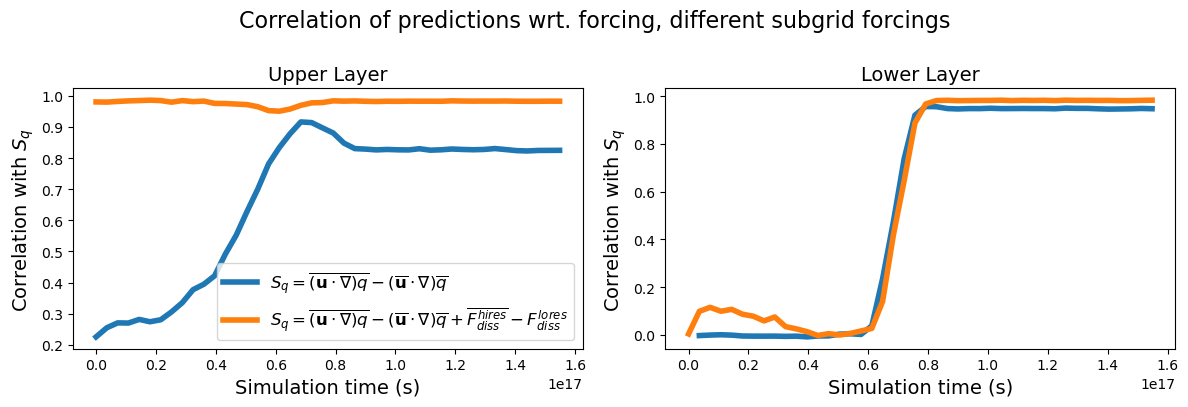

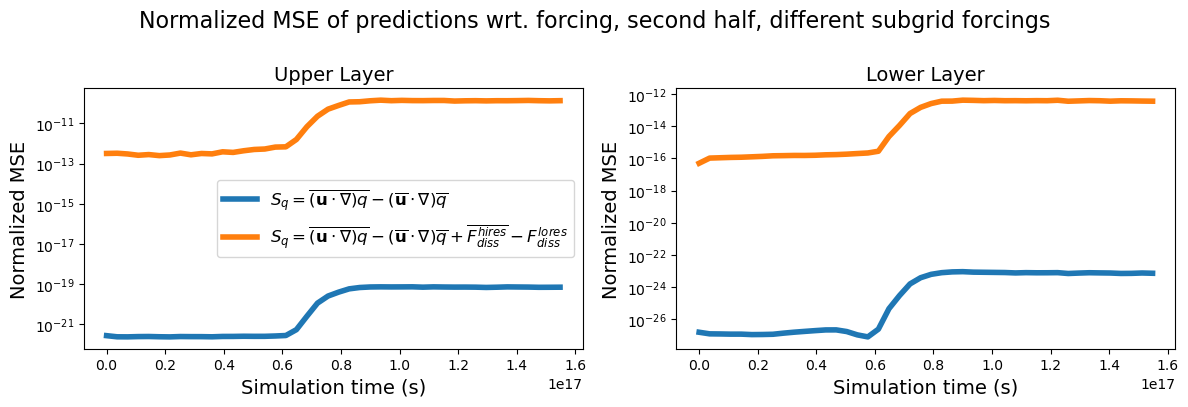

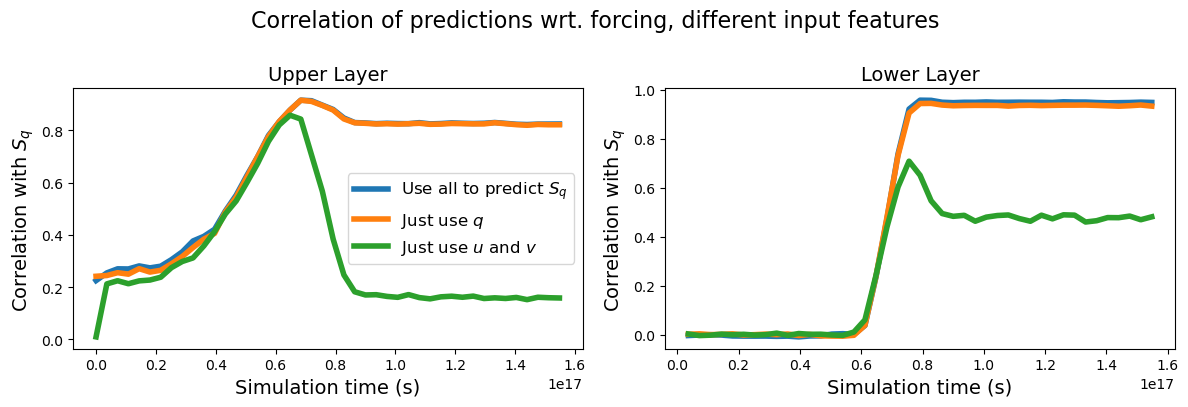

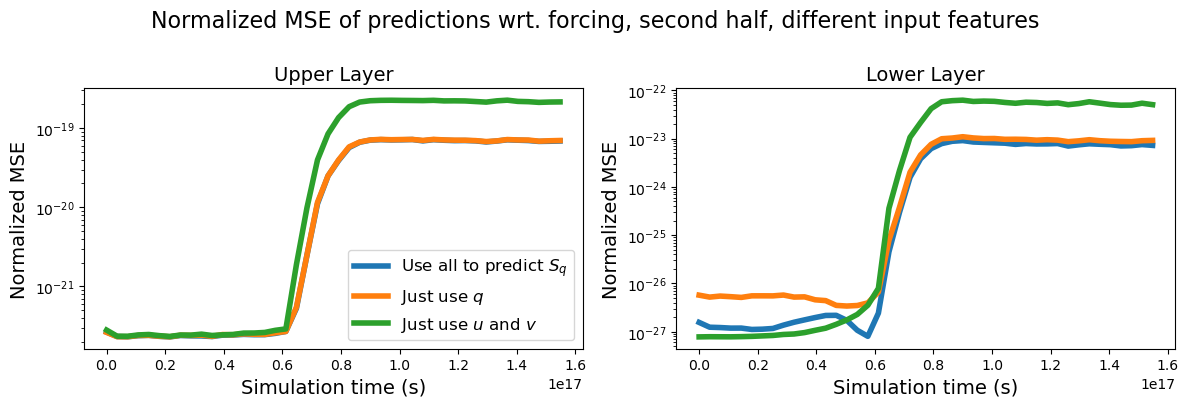

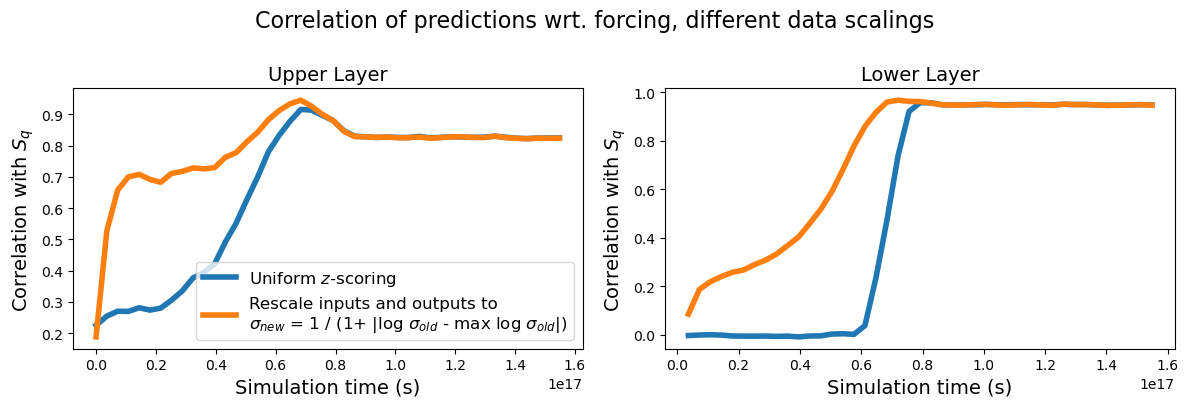

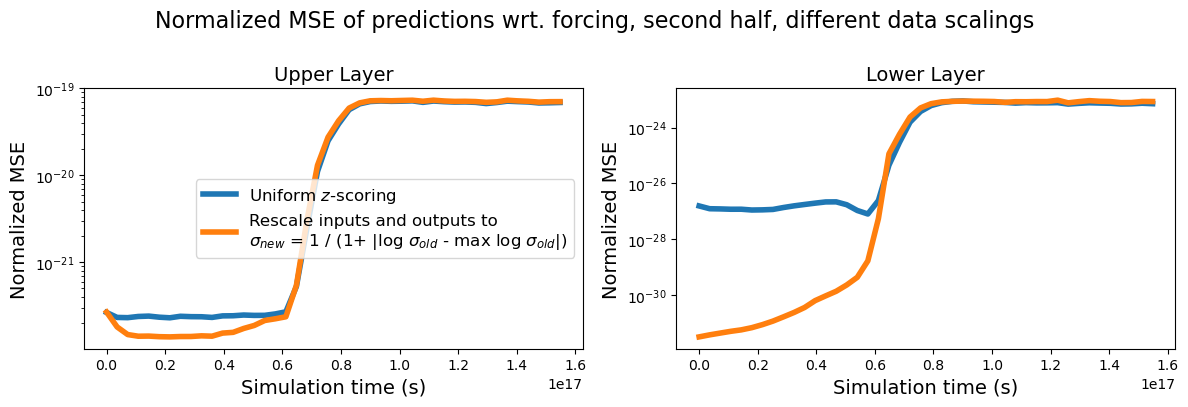

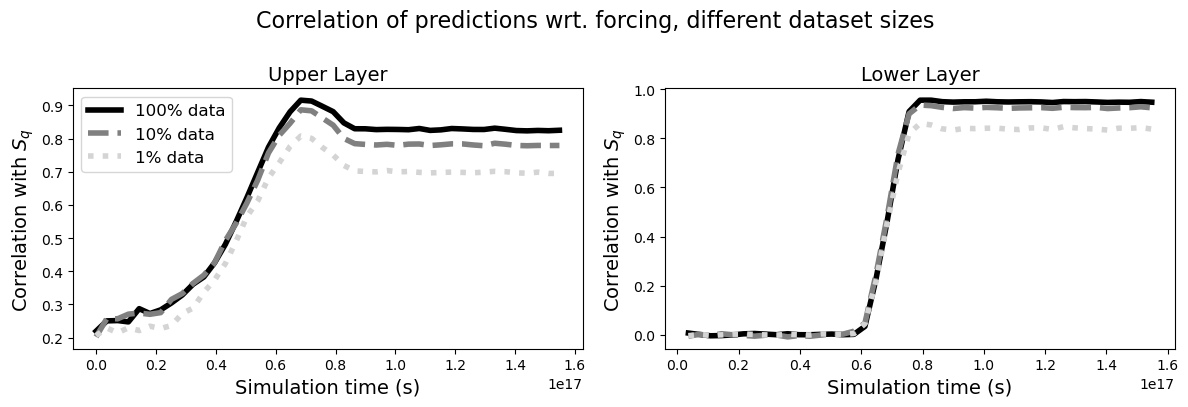

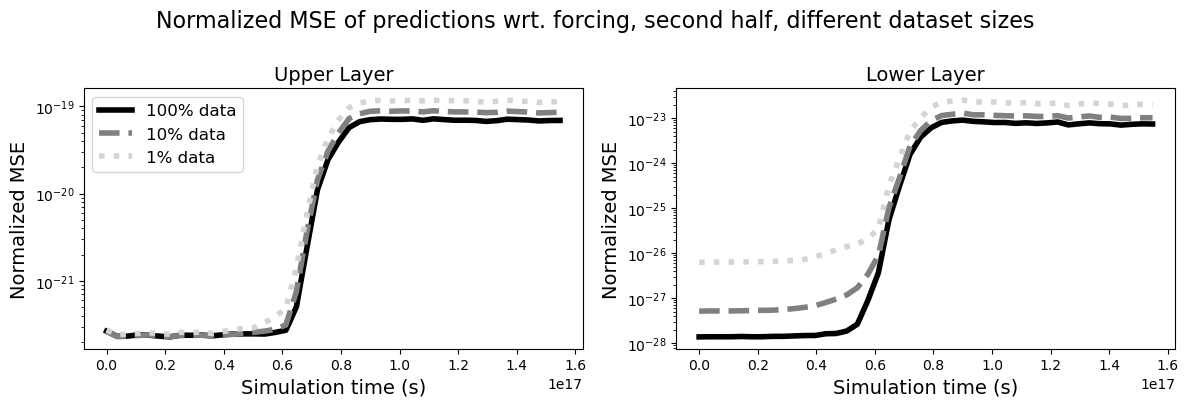

In [9]:
for label, model_opts in comps.items():
    compare_offline_performance(label, model_opts)

In [16]:
def compare_online_performance(label, model_opts,                     
        model_dir="/scratch/zanna/data/pyqg/models",
        data_dir="/scratch/zanna/data/pyqg/64_256/test",
        show_physical=False
    ):
        
    lores = xr.concat(
        [xr.open_dataset(f"{data_dir}/{n}/control.nc") for n in range(8)], "run"
    ).assign_attrs(plot_kwargs=dict(label='Lo-res', color='darkgoldenrod', ls='--'))

    hires = xr.concat(
        [xr.open_dataset(f"{data_dir}/{n}/lores.nc") for n in range(8)], "run"
    ).assign_attrs(plot_kwargs=dict(label='Hi-res (downscaled)', color='darkgoldenrod'))

    runs = [lores, hires]
    
    if show_physical:
        runs.append(xr.concat(
            [xr.open_dataset(f"{data_dir}/{n}/physical.nc") for n in range(8)], "run"
        ).assign_attrs(plot_kwargs=dict(label='Physical Param.', color='gray')))
    
    models = list(sorted(model_opts.keys()))
    
    ps = 1 if 'transfer' in data_dir else 0

    for m in models:
        runs.append(xr.concat(
            [xr.open_dataset(f) for f in glob.glob(f"{model_dir}/{m}/*/pyqg_runs/paramsets/{ps}/*.nc")], "run"
        ).assign_attrs(plot_kwargs=model_opts[m]))

    with figure_grid(2, len(runs), rowwidth=len(runs)*4, rowheight=3.75) as g:
        g.title(f"Final potential vorticity values, {label}", y=0.95, fontsize=20)
        for z, layer in zip([0,1], ['upper','lower']):
            for run in runs:
                g.next()
                run.q.isel(time=-1, lev=z, run=-1).plot(cbar_kwargs=dict(label='$q_'+str(z+1)+'$'))
                plt.title(f"{run.attrs['plot_kwargs']['label']}\n{layer} layer", fontsize=14)
                plt.xlabel('x'); plt.xticks([])
                plt.ylabel('y'); plt.yticks([])    
    
    with figure_grid(1,2,rowheight=4) as g:
        g.title(f"Spectra averaged across repeated simulations, {label}", y=0.95)
        g.next()
        plot_spectra('KEspec', runs, z='sum')
        plt.title("Kinetic Energy", fontsize=14)
        g.next()
        plot_spectra('entspec', runs, leg=False)
        plt.title("Enstrophy", fontsize=14)

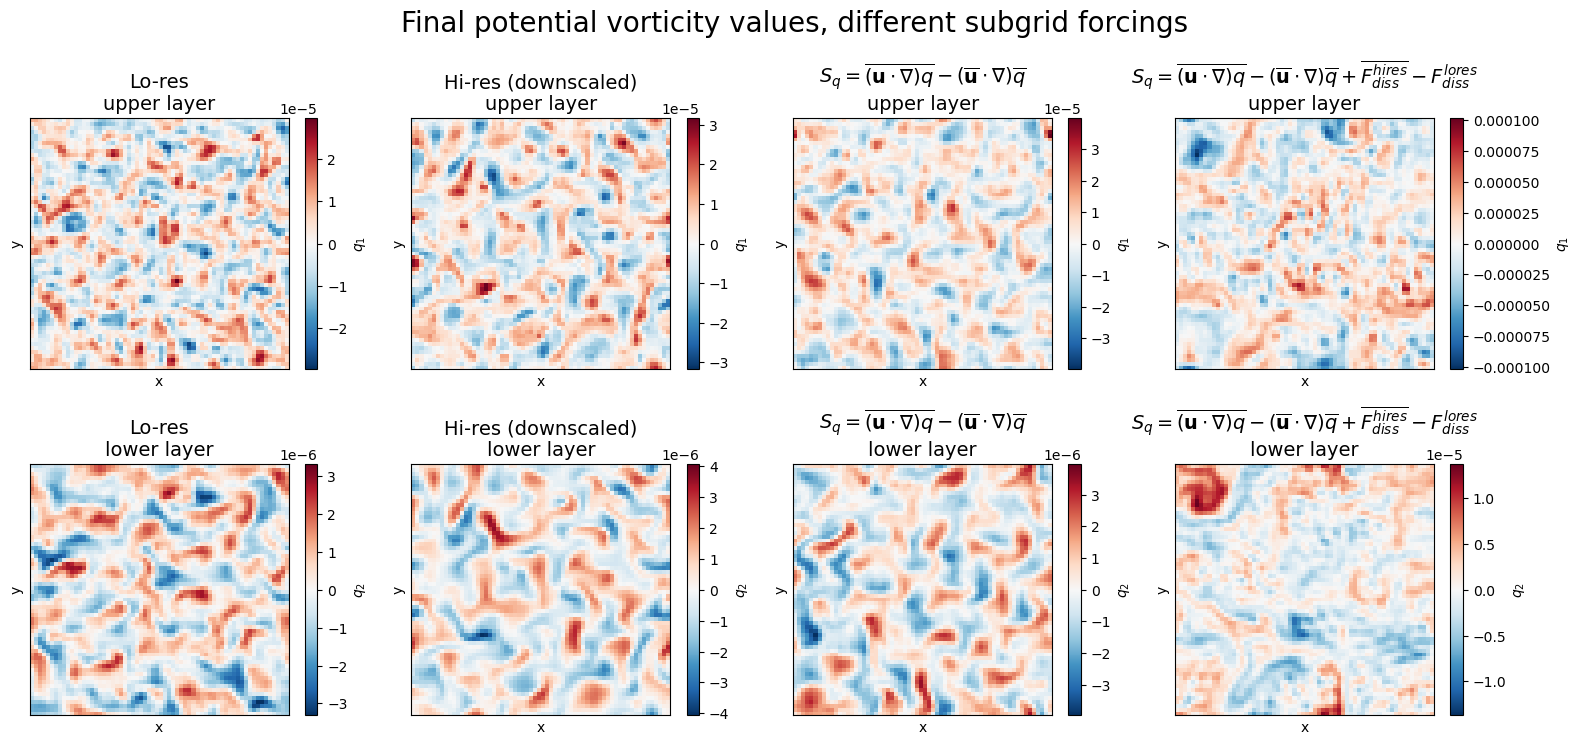

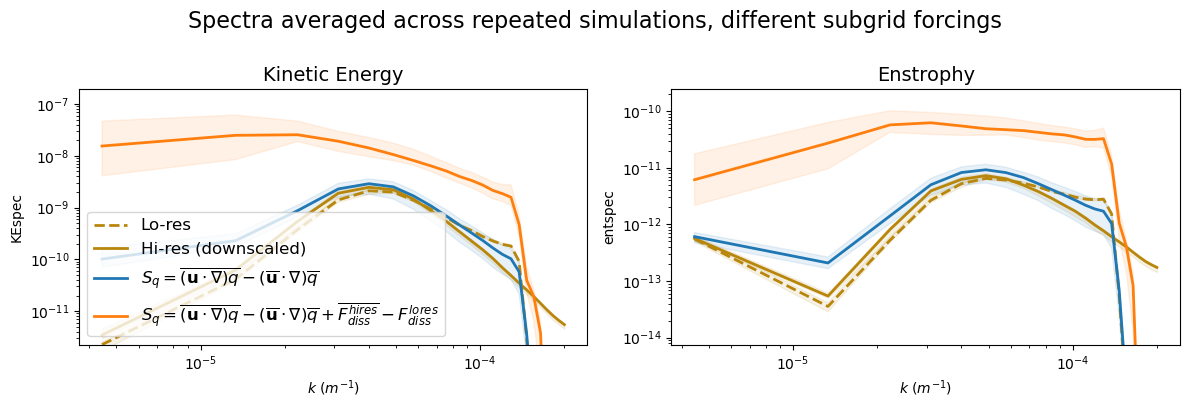

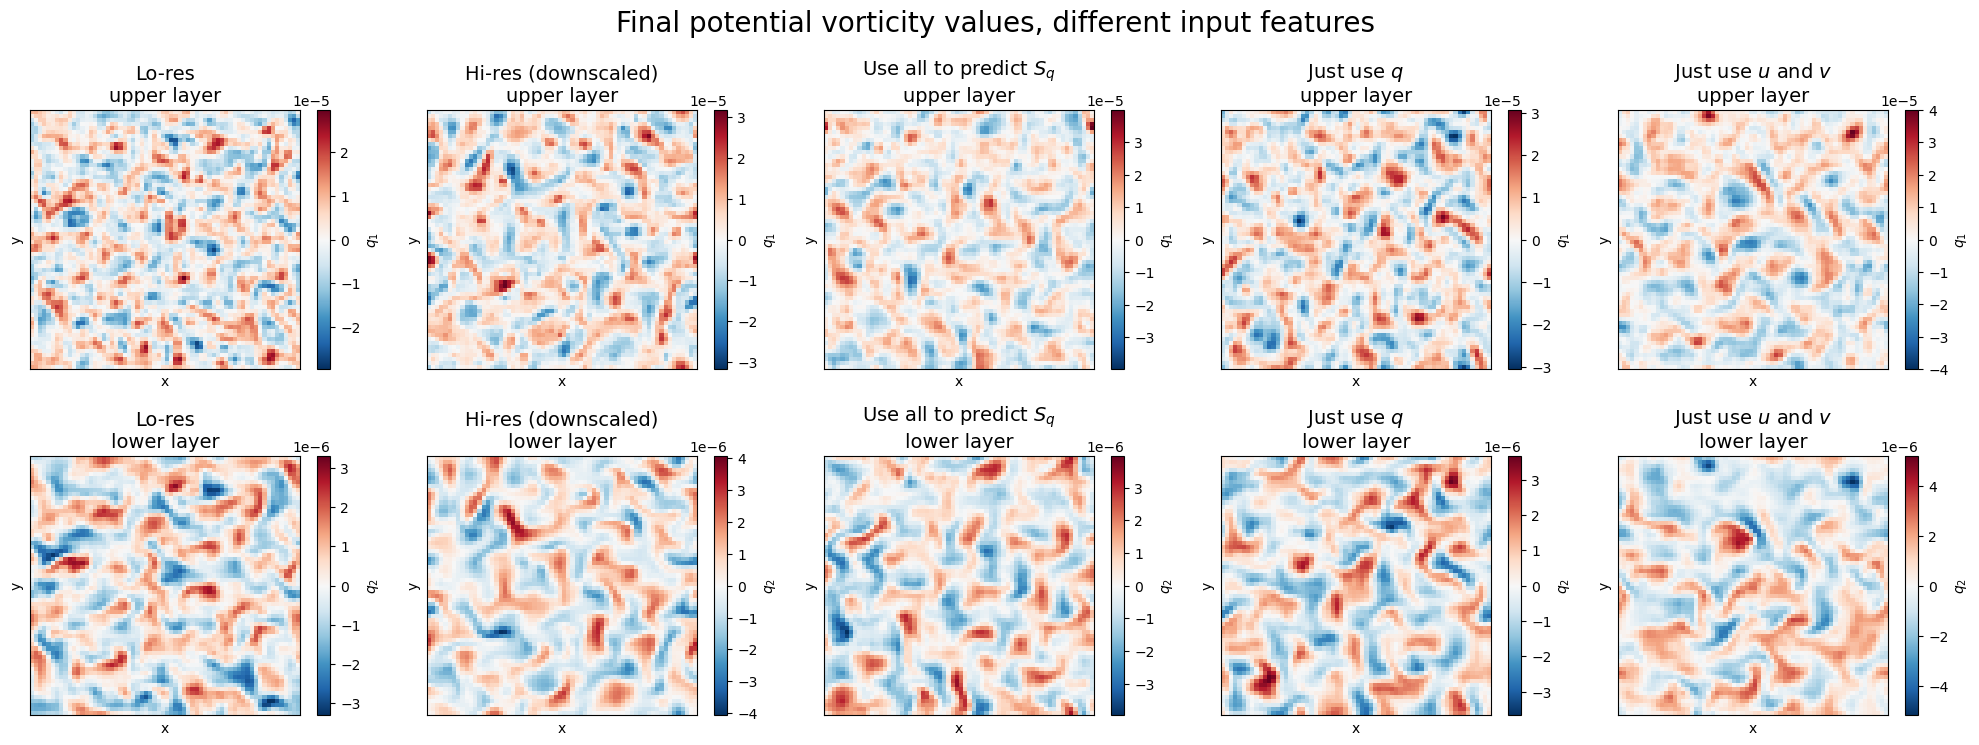

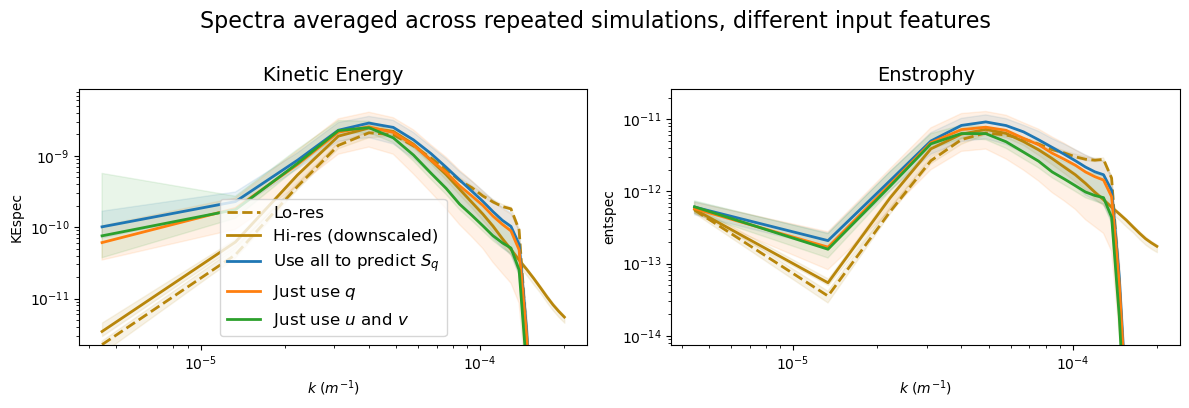

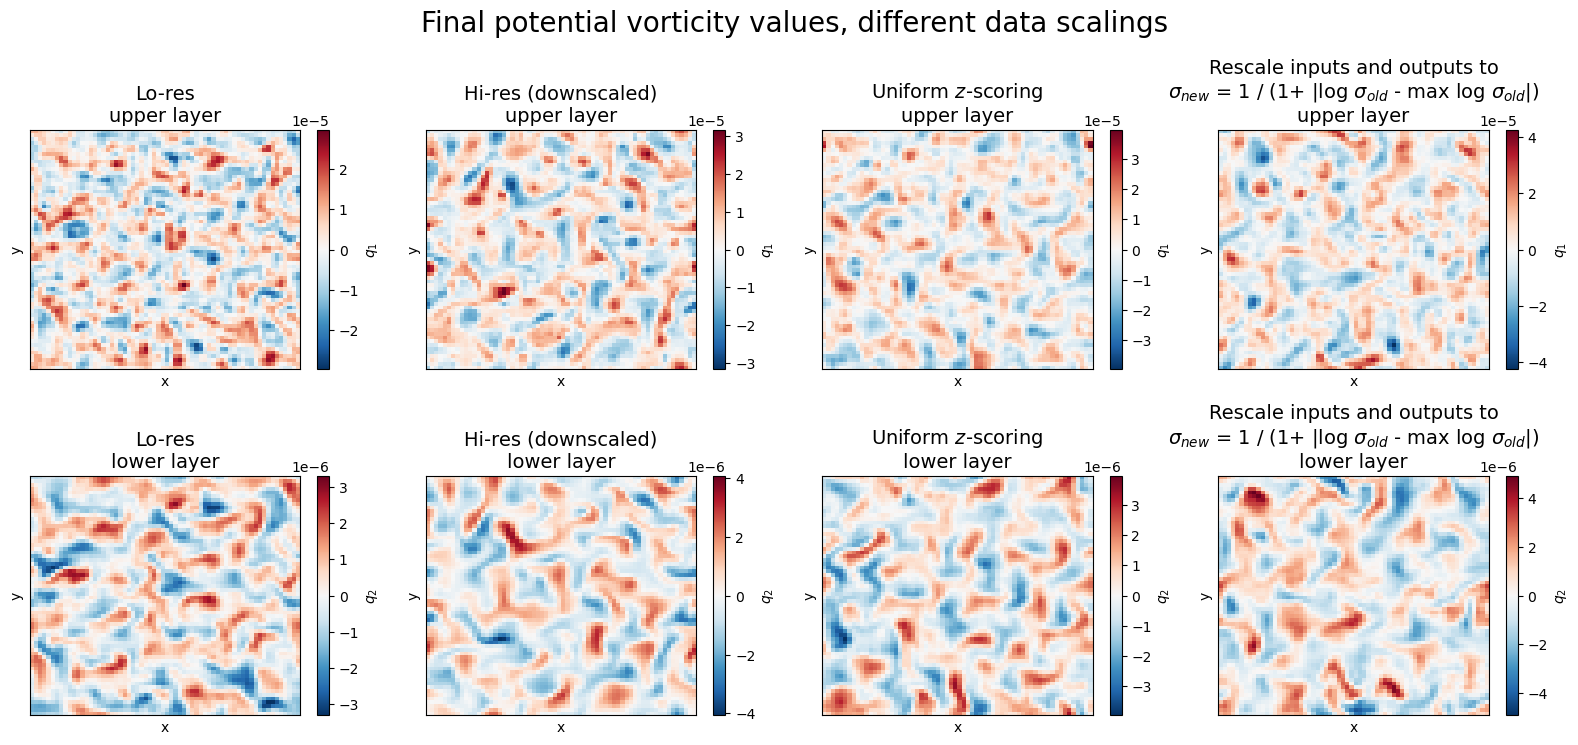

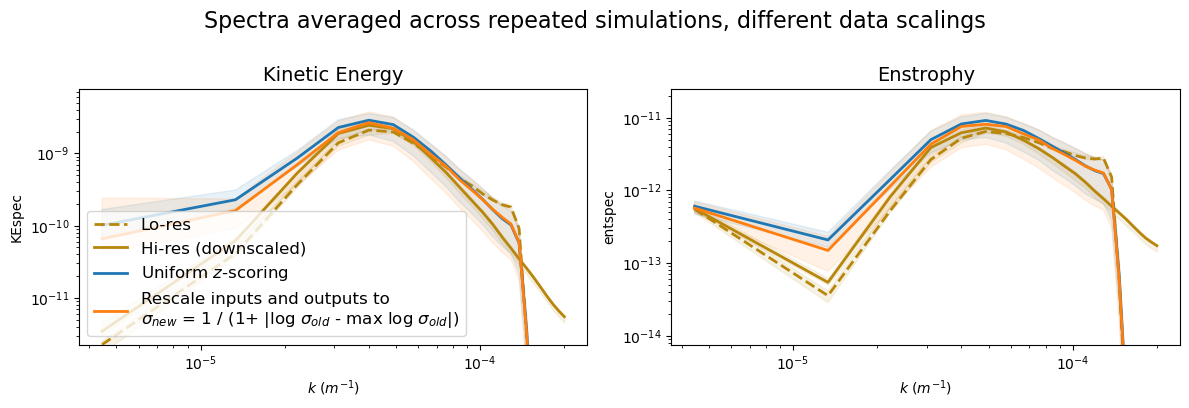

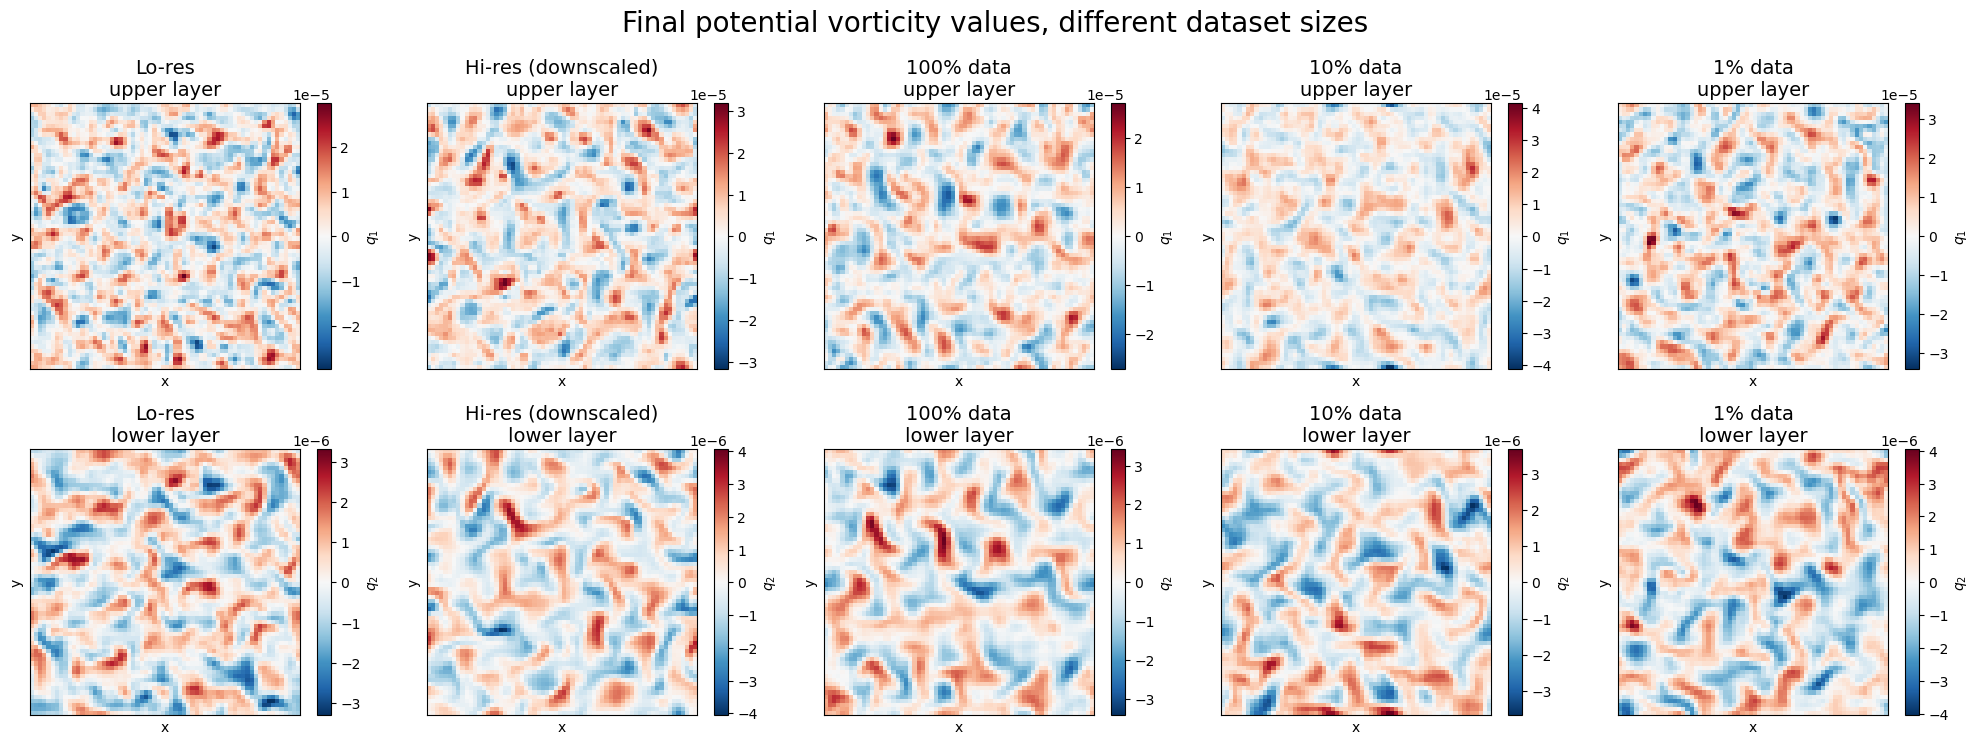

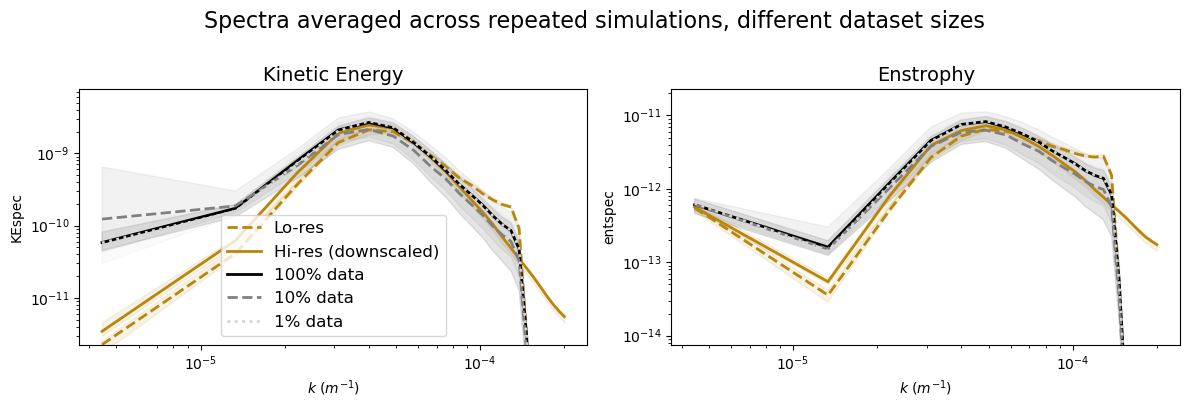

In [17]:
for label, model_opts in comps.items():
    compare_online_performance(label, model_opts)

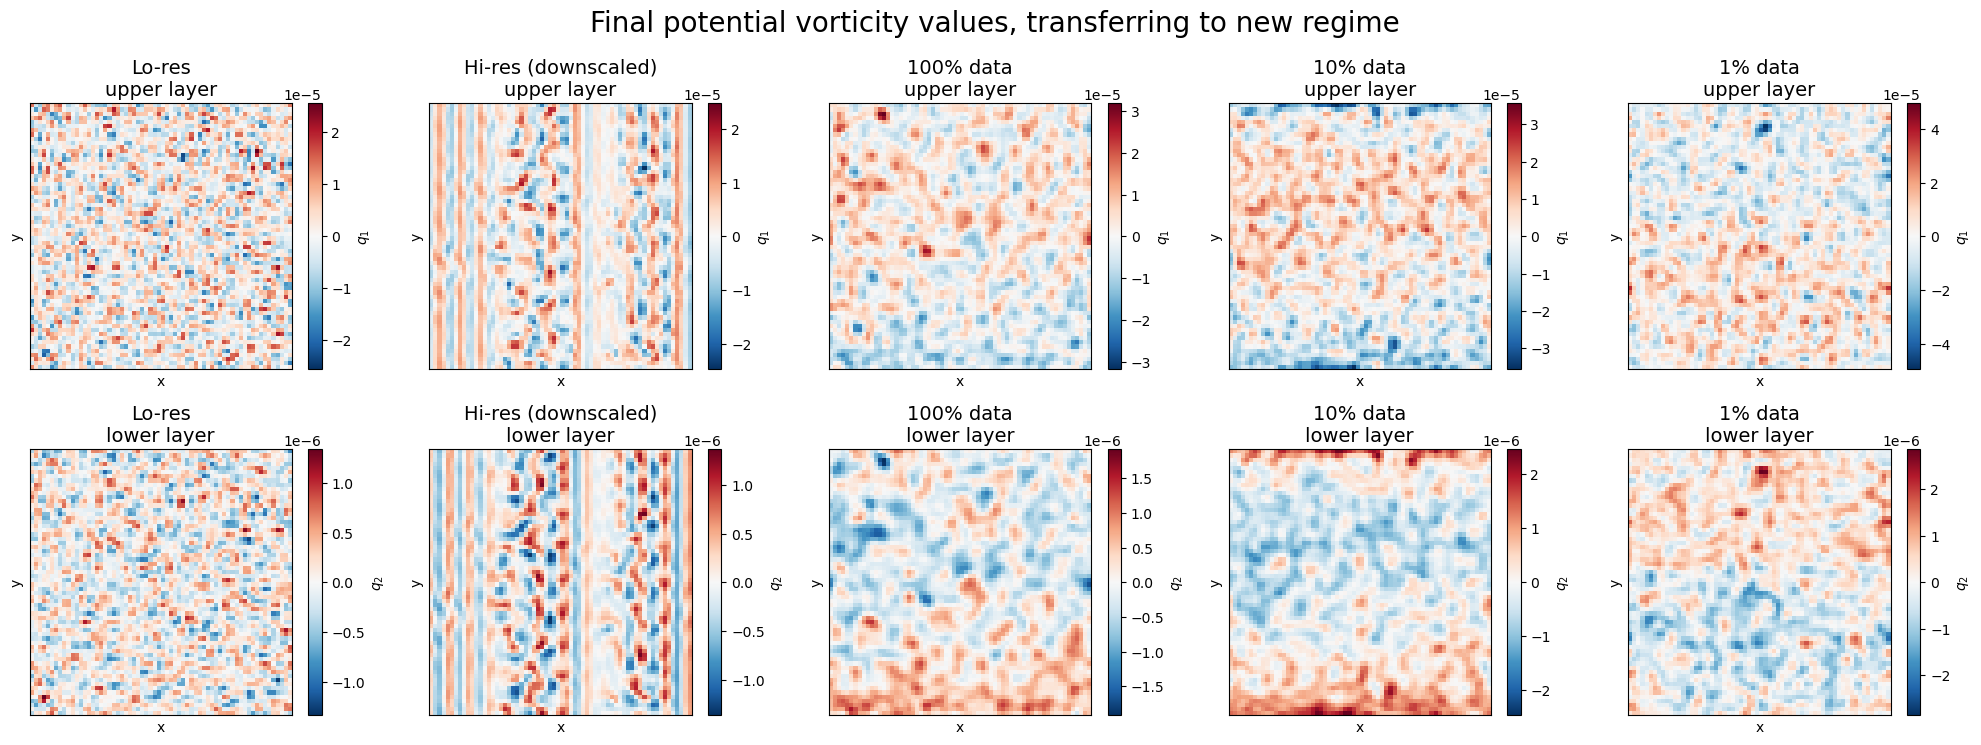

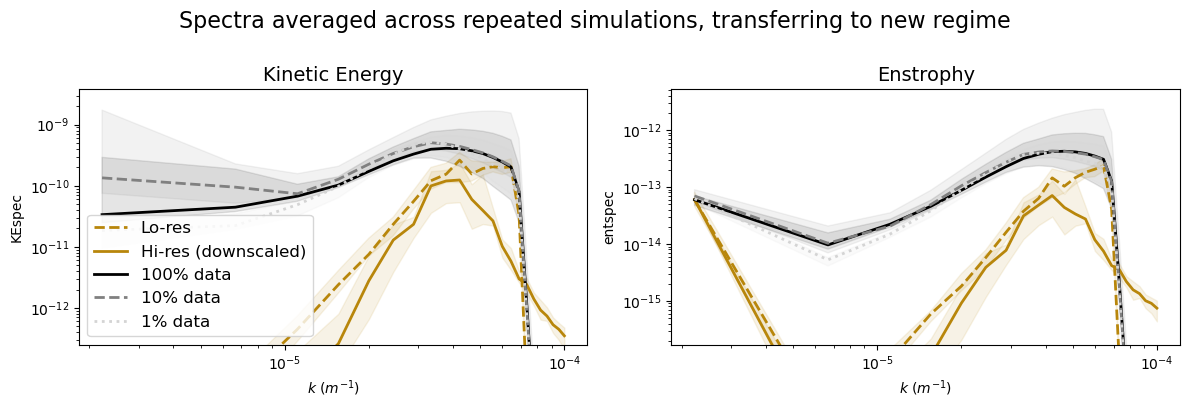

In [18]:
model_opts = comps["different dataset sizes"]
compare_online_performance("transferring to new regime", model_opts, data_dir="/scratch/zanna/data/pyqg/64_256/transfer")